In [1]:
%matplotlib inline

In [2]:
import sys
import time
import numpy as np
import pandas as pd
import nibabel as nib
import pathlib as pal
import seaborn as sbn
from nilearn import image as nimg
from sklearn import metrics as skm
from nilearn import plotting as nlp
from matplotlib import pyplot as plt
from matplotlib import gridspec as gs
from matplotlib.colors import ListedColormap

/home/surchs/conda/envs/svip/lib/python3.6/site-packages/nilearn/plotting/__init__.py:20: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use('Agg')


In [43]:
# Paths
root_p = pal.Path('/home/surchs/data/ATLAS/')
yeo7_p = root_p / 'Yeo/Yeo_JNeurophysiol11_MNI152/Yeo2011_7Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz'
yeo17_p = root_p / 'Yeo/Yeo_JNeurophysiol11_MNI152/Yeo2011_17Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz'
mist7_p = root_p / 'MIST/Parcellations/MIST_7.nii.gz'
mist20_p = root_p / 'MIST/Parcellations/MIST_20.nii.gz'
fig_p = pal.Path('/home/surchs/data/surchs/mist_parcellation/figures')
if not fig_p.is_dir():
    fig_p.mkdir()

In [4]:
yeo7_i = nib.load(str(yeo7_p))
yeo17_i = nib.load(str(yeo17_p))
mist7_i = nib.load(str(mist7_p))
mist20_i = nib.load(str(mist20_p))

In [5]:
# Resample
mist7_res_i = nimg.resample_to_img(mist7_i, yeo7_i, interpolation='nearest')
mist20_res_i = nimg.resample_to_img(mist20_i, yeo7_i, interpolation='nearest')

In [6]:
# Get the parcellations and mask data
yeo7 = yeo7_i.get_data().squeeze()
yeo17 = yeo17_i.get_data().squeeze()

yeo_mask = np.zeros(yeo7.shape).astype(bool)
yeo_mask[yeo7!=0] = True

mist7 = mist7_res_i.get_data()
mist20 = mist20_res_i.get_data()
mist20_combined = np.copy(mist20)
# Merge anterior and lateral DMN
mist20_combined[(mist20==13)|(mist20==18)] = 100
# Merge medial and lateral ventral attention
mist20_combined[(mist20==12)|(mist20==19)] = 200
# Merge ventral somatomotor and auditory network
mist20_combined[(mist20==8)|(mist20==2)] = 300

mist_mask7 = np.zeros(mist7.shape).astype(bool)
mist_mask20 = np.zeros(mist7.shape).astype(bool)
mist_mask7[mist7!=0] = True
mist_mask20[mist7!=0] = True
# Also mask the cerebellum
mist_mask7[mist7==1] = False
mist_mask20[(mist20==4)|(mist20==17)] = False
# Also remove subcortical areas
mist_mask20[(mist20==1)|(mist20==10)] = False

## Build a consensus mask

In [7]:
consensus_mask7 = yeo_mask & mist_mask7
consensus_mask20 = yeo_mask & mist_mask20
consensus_mask7_i = nib.Nifti1Image(consensus_mask7, yeo7_i.affine, header=yeo7_i.header)
consensus_mask20_i = nib.Nifti1Image(consensus_mask20, yeo7_i.affine, header=yeo7_i.header)

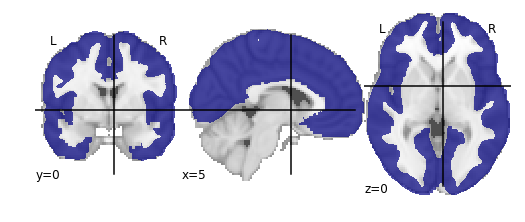

In [8]:
nlp.plot_roi(consensus_mask20_i, cut_coords=(5,0,0));

In [9]:
# Mask the parcellations
yeo7_7m = yeo7[consensus_mask7]
yeo17_20m = yeo17[consensus_mask20]

mist7_m = mist7[consensus_mask7]
mist20_m = mist20[consensus_mask20]
mist20_c_m = mist20_combined[consensus_mask20]

## Compute percent overlap

In [12]:
def map_to_vol(values, mask):
    vol = np.zeros(mask.shape)
    vol[mask] = values
    return vol

In [13]:
def get_max_mc(reference, mask):
    candidates = np.unique(reference[mask])
    overlap = [skm.adjusted_mutual_info_score(reference==cand, mask) for cand in candidates]
    return np.max(overlap), candidates[np.argmax(overlap)]

In [14]:
def get_max_dice(reference, mask):
    candidates = np.unique(reference[mask])
    overlap = [skm.f1_score(reference==cand, mask) for cand in candidates]
    return np.max(overlap), candidates[np.argmax(overlap)]

In [15]:
def get_max_overlap(reference, mask):
    # Now we only care how much of the parcel of interest is inside a candidate parcel of the reference
    candidates = np.unique(reference[mask])
    n_voxel = np.sum(mask)
    overlap = [np.sum(mask[reference==cand])/n_voxel for cand in candidates]
    return np.max(overlap), candidates[np.argmax(overlap)]

In [16]:
def get_mc(to_test, to_compare):
    po_list = list()
    po_parcel_list = list()
    po_vol = np.zeros(to_test.shape)
    regions = np.unique(to_test)
    regions = regions[regions!=0]
    for region in regions:
        po, po_parcel = get_max_mc(to_compare, to_test==region)
        po_vol[to_test==region] = po
        po_list.append(po)
        po_parcel_list.append(po_parcel)
    return (po_vol, po_list, po_parcel_list)

In [17]:
def get_dice(to_test, to_compare):
    po_list = list()
    po_parcel_list = list()
    po_vol = np.zeros(to_test.shape)
    regions = np.unique(to_test)
    regions = regions[regions!=0]
    for region in regions:
        po, po_parcel = get_max_dice(to_compare, to_test==region)
        po_vol[to_test==region] = po
        po_list.append(po)
        po_parcel_list.append(po_parcel)
    return (po_vol, po_list, po_parcel_list)

In [18]:
def get_overlap(to_test, to_compare):
    po_list = list()
    po_parcel_list = list()
    po_vol = np.zeros(to_test.shape)
    regions = np.unique(to_test)
    regions = regions[regions!=0]
    for region in regions:
        po, po_parcel = get_max_overlap(to_compare, to_test==region)
        po_vol[to_test==region] = po
        po_list.append(po)
        po_parcel_list.append(po_parcel)
    return (po_vol, po_list, po_parcel_list)

In [19]:
f1_yeo7_mist7, f1_list_yeo7_mist7, f1_parcel_list_yeo7_mist7 = get_dice(mist7_m, yeo7_7m)
f1_yeo17_mist20, f1_list_yeo17_mist20, f1_parcel_list_yeo17_mist20 = get_dice(mist20_m, yeo17_20m)
f1_yeo17_mist20_c, f1_list_yeo17_mist20_c, f1_parcel_list_yeo17_mist20_c = get_dice(mist20_c_m, yeo17_20m)

In [20]:
po_yeo7_mist7, po_list_yeo7_mist7, po_parcel_list_yeo7_mist7 = get_overlap(mist7_m, yeo7_7m)
po_yeo17_mist20, po_list_yeo17_mist20, po_parcel_list_yeo17_mist20 = get_overlap(mist20_m, yeo17_20m)
po_yeo17_mist20_c, po_list_yeo17_mist20_c, po_parcel_list_yeo17_mist20_c = get_overlap(mist20_c_m, yeo17_20m)

In [21]:
mc_yeo7_mist7, mc_list_yeo7_mist7, mc_parcel_list_yeo7_mist7 = get_mc(mist7_m, yeo7_7m)
mc_yeo17_mist20, mc_list_yeo17_mist20, mc_parcel_list_yeo17_mist20 = get_mc(mist20_m, yeo17_20m)

In [22]:
# Map to volume
po_vol_yeo7_mist7 = map_to_vol(po_yeo7_mist7, consensus_mask7)
po_vol_yeo17_mist20 = map_to_vol(po_yeo17_mist20, consensus_mask20)
po_vol_yeo17_mist20_c = map_to_vol(po_yeo17_mist20_c, consensus_mask20)

f1_vol_yeo7_mist7 = map_to_vol(f1_yeo7_mist7, consensus_mask7)
f1_vol_yeo17_mist20 = map_to_vol(f1_yeo17_mist20, consensus_mask20)
f1_vol_yeo17_mist20_c = map_to_vol(f1_yeo17_mist20_c, consensus_mask20)

mc_vol_yeo7_mist7 = map_to_vol(mc_yeo7_mist7, consensus_mask7)
mc_vol_yeo17_mist20 = map_to_vol(mc_yeo17_mist20, consensus_mask20)

In [23]:
po_img_yeo7_mist7 = nib.Nifti1Image(po_vol_yeo7_mist7, yeo7_i.affine, header=yeo7_i.header)
po_img_yeo17_mist20 = nib.Nifti1Image(po_vol_yeo17_mist20, yeo7_i.affine, header=yeo7_i.header)
po_img_yeo17_mist20_c = nib.Nifti1Image(po_vol_yeo17_mist20_c, yeo7_i.affine, header=yeo7_i.header)

f1_img_yeo7_mist7 = nib.Nifti1Image(f1_vol_yeo7_mist7, yeo7_i.affine, header=yeo7_i.header)
f1_img_yeo17_mist20 = nib.Nifti1Image(f1_vol_yeo17_mist20, yeo7_i.affine, header=yeo7_i.header)
f1_img_yeo17_mist20_c = nib.Nifti1Image(f1_vol_yeo17_mist20_c, yeo7_i.affine, header=yeo7_i.header)

mc_img_yeo7_mist7 = nib.Nifti1Image(mc_vol_yeo7_mist7, yeo7_i.affine, header=yeo7_i.header)
mc_img_yeo17_mist20 = nib.Nifti1Image(mc_vol_yeo17_mist20, yeo7_i.affine, header=yeo7_i.header)

## Detect the boundary region on the Yeo parcels

In [24]:
def detect_borders(atlas, folds=1):
    start = time.time()
    touch_3d = np.array([[-1, 1, 0, 0, 0, 0],
                     [0, 0, -1, 1, 0, 0],
                     [0, 0, 0, 0, -1, 1]])
    
    test_atlas = np.copy(atlas)
    borders = np.zeros_like(test_atlas)
    atlas_inds = np.argwhere(test_atlas!=0)
    n_inds = len(atlas_inds)
    
    for fold in np.arange(folds):
        for coord_id, coord in enumerate(atlas_inds):
            neighbour_coords = tuple(map(tuple, (touch_3d.T+coord).T))
            # Find the difference between the coordinate and its neighbours
            neighbour_diff = np.setdiff1d(test_atlas[neighbour_coords], 
                                          test_atlas[tuple(coord)])
            # See if this coordinate touches borders
            if len(neighbour_diff[neighbour_diff!=0])>0:
                borders[tuple(coord)] = folds-fold
            if coord_id%10000==0 and not coord_id==0:
                elapsed = time.time() - start
                done = ((fold*n_inds)+coord_id)
                remaining = n_inds*folds - done
                time_left = (elapsed/done)*remaining
                sys.stdout.write('\r {:.2E}/{:.2E}. {:.2f}s left)'.format(done, n_inds*folds, time_left))
                sys.stdout.flush()
        test_atlas[borders!=0] = 999
    return borders

In [25]:
# Map the masked atlases back to volume space
yeo7_7mask = map_to_vol(yeo7_7m, consensus_mask7)
yeo17_20mask = map_to_vol(yeo17_20m, consensus_mask20)
mist7_mask = map_to_vol(mist7_m, consensus_mask7)
mist20_mask = map_to_vol(mist20_m, consensus_mask20)

yeo7_7mask_i = nib.Nifti1Image(yeo7_7mask, affine=yeo7_i.affine, header=yeo7_i.header)
yeo17_20mask_i = nib.Nifti1Image(yeo17_20mask, affine=yeo7_i.affine, header=yeo7_i.header)

mist7_mask_i = nib.Nifti1Image(mist7_mask, affine=yeo7_i.affine, header=yeo7_i.header)
mist20_mask_i = nib.Nifti1Image(mist20_mask, affine=yeo7_i.affine, header=yeo7_i.header)

In [28]:
borders_yeo7_i = nib.Nifti1Image(borders_yeo7, affine=yeo7_i.affine, header=yeo7_i.header)
borders_yeo17_i = nib.Nifti1Image(borders_yeo17, affine=yeo7_i.affine, header=yeo7_i.header)

In [30]:
nib.save(borders_yeo7_i, str(fig_p / 'border_yeo_7.nii.gz'))
nib.save(borders_yeo17_i, str(fig_p / 'border_yeo_17.nii.gz'))

## Plot the percent overlap

In [32]:
# Compute the actual dice values
dy7m7 = [[name, dice] for name, dice in zip(['f1_y7m7']*len(f1_list_yeo7_mist7), 
                                           f1_list_yeo7_mist7)]
dy17m20 = [[name, dice] for name, dice in zip(['f1_y17m20']*len(f1_list_yeo17_mist20), 
                                           f1_list_yeo17_mist20)]
dy17m20_c = [[name, dice] for name, dice in zip(['f1_y17m20_c']*len(f1_list_yeo17_mist20_c), 
                                           f1_list_yeo17_mist20_c)]
data = dy7m7 + dy17m20 + dy17m20_c
dice = pd.DataFrame(data=data, columns=['comparison', 'dice'])

# Plot the actual dice values
oy7m7 = [[name, overlap] for name, overlap in zip(['po_y7m7']*len(po_list_yeo7_mist7), 
                                           po_list_yeo7_mist7)]
oy17m20 = [[name, overlap] for name, overlap in zip(['po_y17m20']*len(po_list_yeo17_mist20), 
                                           po_list_yeo17_mist20)]
oy17m20_c = [[name, overlap] for name, overlap in zip(['po_y17m20c']*len(po_list_yeo17_mist20_c), 
                                           po_list_yeo17_mist20_c)]

my7m7 = [[name, mc] for name, mc in zip(['mc_y7m7']*len(mc_list_yeo7_mist7), 
                                           mc_list_yeo7_mist7)]
my17m20 = [[name, mc] for name, mc in zip(['mc_y17m20']*len(mc_list_yeo17_mist20), 
                                           mc_list_yeo17_mist20)]


data = dy7m7 + dy17m20 + oy7m7 + oy17m20 + my7m7 + my17m20
dice = pd.DataFrame(data=data, columns=['comparison', 'dice'])

In [35]:
po_y7_m7 = np.array([list(e) for e in zip(np.unique(mist7_m), po_list_yeo7_mist7, po_parcel_list_yeo7_mist7)])
po_y17_m20 = np.array([list(e) for e in zip(np.unique(mist20_m), po_list_yeo17_mist20, po_parcel_list_yeo17_mist20)])
po_y17_m20_c = np.array([list(e) for e in zip(np.unique(mist20_c_m), po_list_yeo17_mist20_c, po_parcel_list_yeo17_mist20_c)])

f1_y7_m7 = np.array([list(e) for e in zip(np.unique(mist7_m), f1_list_yeo7_mist7, f1_parcel_list_yeo7_mist7)])
f1_y17_m20 = np.array([list(e) for e in zip(np.unique(mist20_m), f1_list_yeo17_mist20, f1_parcel_list_yeo17_mist20)])
f1_y17_m20_c = np.array([list(e) for e in zip(np.unique(mist20_c_m), f1_list_yeo17_mist20_c, f1_parcel_list_yeo17_mist20_c)])

mc_y7_m7 = np.array([list(e) for e in zip(np.unique(mist7_m), mc_list_yeo7_mist7, mc_parcel_list_yeo7_mist7)])
mc_y17_m20 = np.array([list(e) for e in zip(np.unique(mist20_m), mc_list_yeo17_mist20, mc_parcel_list_yeo17_mist20)])

In [36]:
np.unique([i[2] for i in zip(np.unique(mist20_m), po_list_yeo17_mist20, po_parcel_list_yeo17_mist20)])

array([ 1.,  2.,  3.,  4.,  5.,  7.,  9., 10., 12., 13., 16., 17.],
      dtype=float32)

In [37]:
colors = plt.cm.get_cmap('viridis_r').colors
new_colors = colors + colors[::-1]
double_viridis = ListedColormap(new_colors, name='double_viridis')

In [56]:
def make_column_figure(percent_overlap, borders, mist, mist_scale):
    f = plt.figure(figsize=(20,9))
    grids = gs.GridSpec(nrows=3, ncols=2, hspace=0.3, wspace=0)
    cuts = [
    (5, 0, 10),
    (-20, -20, -5),
    (20, 20, 50)
    ]
    for i in range(3):
        ax_l = f.add_subplot(grids[i, 0])
        ax_r = f.add_subplot(grids[i, 1])
        if i==1:
            cb = False
        else:
            cb=False
        display_left = nlp.plot_stat_map(percent_overlap, cut_coords=cuts[i], colorbar=cb,annotate=False, 
                                         draw_cross=False, cmap=double_viridis, axes=ax_l);
        display_left.add_contours(mist, antialiased=False,
                             linewidths=1, levels=np.arange(mist_scale), colors=['black'], alpha=0.8);
            

        display_right = nlp.plot_stat_map(borders, cut_coords=cuts[i], colorbar=False, annotate=False,
                                          draw_cross=False, axes=ax_r);
        display_right.add_contours(mist, antialiased=False,
                         linewidths=1, levels=np.arange(mist_scale)+1, colors=['black'], alpha=0.8);
    return f

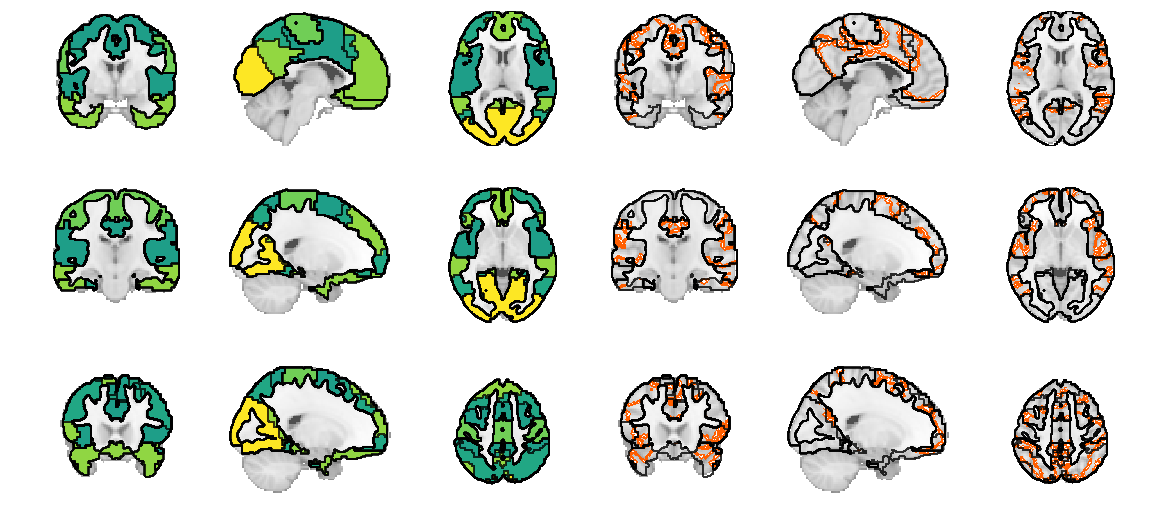

In [57]:
fig_yeo7_mist7 = make_column_figure(f1_img_yeo7_mist7, borders_yeo7_i, mist7_mask_i, 7)
fig_yeo7_mist7.savefig(str(fig_p / 'yeo_reproducibility_scale_7_no_colorbar.pdf'), dpi=300, transparent=True)

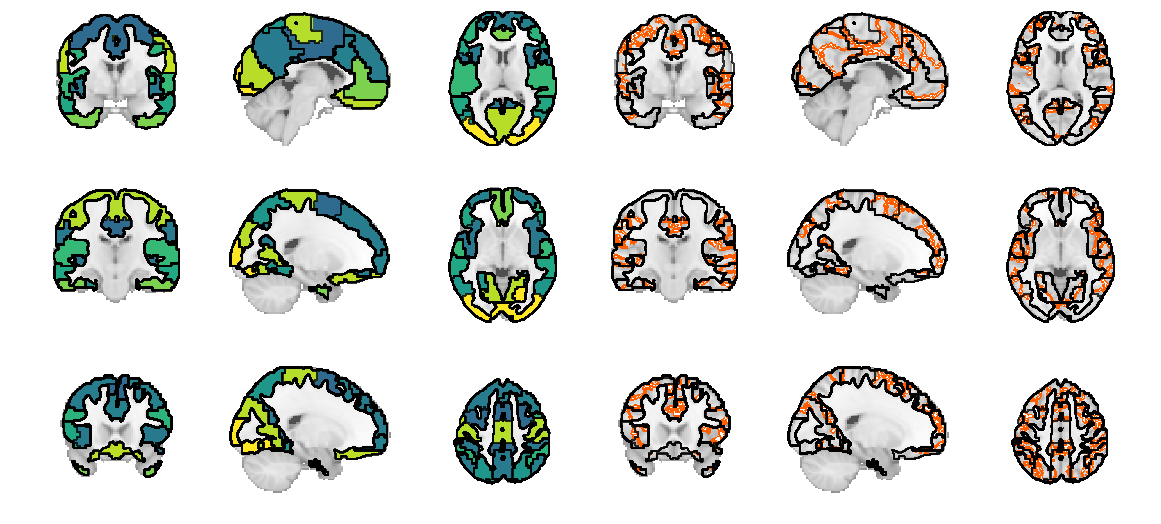

In [58]:
fig_yeo17_mist20 = make_column_figure(po_img_yeo17_mist20, borders_yeo17_i, mist20_mask_i, 20)
fig_yeo17_mist20.savefig(str(fig_p / 'yeo_reproducibility_scale_17_no_colorbar.pdf'), dpi=300, transparent=True)